# Modelling the behavior of a damped double pendulum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle
from sklearn import preprocessing

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
np.random.seed(1337)  # for reproducibility

raw_data = pd.read_csv("MAP_WhitePen1.csv", na_filter=False)

# The first 5 rows of the csv
print(raw_data.head(5))

   VideoAnalysis: Time (s)  VideoAnalysis: X  VideoAnalysis: Y  \
0                 0.000000          5.816870          2.713342   
1                17.984633          0.259602        536.029317   
2                27.827800        409.940908        156.002507   
3                27.861167        408.413849        152.111882   
4                27.894533        395.640027        142.170234   

   VideoAnalysis: X Velocity  VideoAnalysis: Y Velocity  
0                   7.094623                  17.556862  
1                  14.407010                   5.374901  
2                  27.572473                 -17.006521  
3                 -92.153838                -116.531409  
4                -287.258757                -258.118791  


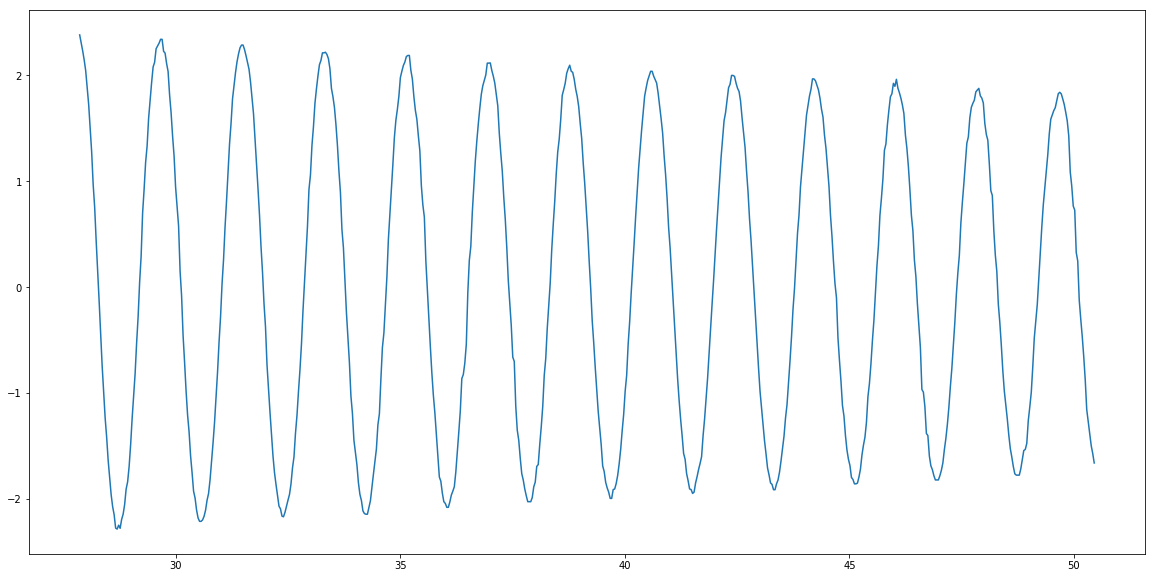

In [51]:
window = 1
edge = int(np.ceil(window/2))

def preprocess(data):
    # Calculate the moving average
    data = data.rolling(window=window,center=True).mean()
    # Trim the data that wasn't part of the moving average
    data = data[edge:-edge]
    # Standardize the data
    return preprocessing.scale(data) 

time_data = raw_data["VideoAnalysis: Time (s)"][edge:-edge].values
X_data = preprocess(raw_data["VideoAnalysis: X"])
Y_data = preprocess(raw_data["VideoAnalysis: Y"])

a = 2
b = 680
data = X_data[a:b]
time = time_data[a:b]
plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(time, data)

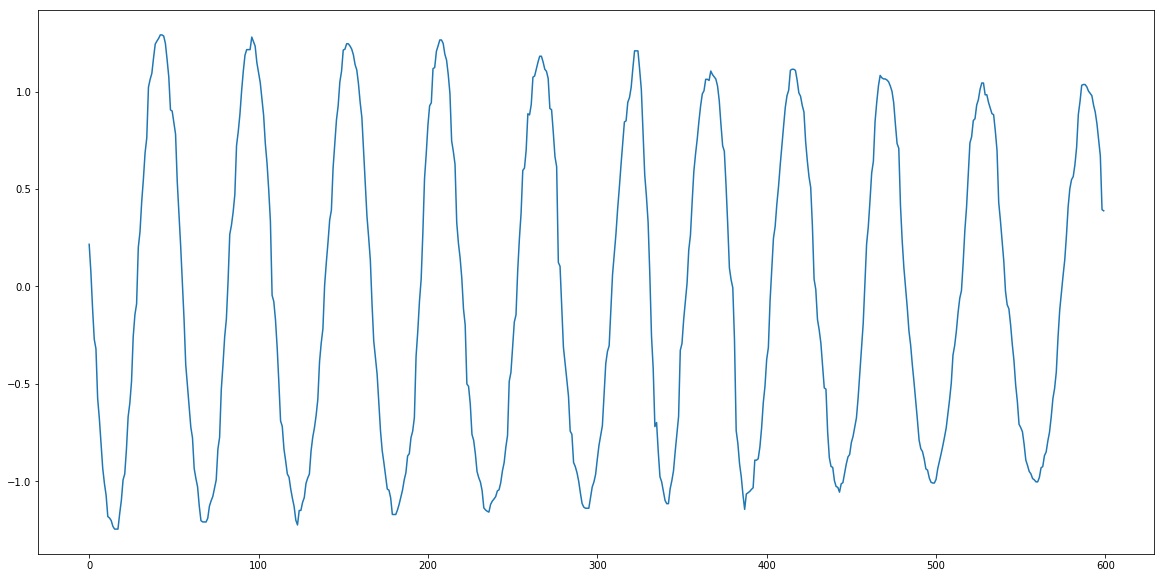

In [52]:
c = 700
d = 1300
data1 = X_data[c:d]
time1 = time_data[c:d]
plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(data1)

In [53]:
# hyperparameters
DATA_DIM = 1
N_PREV = 100 # number of previous steps used to predict the next step

In [54]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for j in range(len(data)-n_prev):
        docX.append(data[j:j+n_prev])
        docY.append(data[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data, test_size=0.6):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))

    X_train, y_train = _load_data(data[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(data[ntrn:])

    return (X_train, y_train), (X_test, y_test)


# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.2)

# extra data
(X_train1, y_train1), (X_test1, y_test1) = train_test_split(data1, 0.2)
X_train = np.append(X_train, X_train1, axis=0)
y_train = np.append(y_train, y_train1, axis=0)
X_train, y_train = shuffle(X_train, y_train)

In [55]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=200, return_sequences=True), input_shape=(None, 1)))
model.add(Bidirectional(CuDNNLSTM(units=100, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=50, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [57]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_split=0.05)

Train on 780 samples, validate on 42 samples
Epoch 1/25


ResourceExhaustedError: OOM when allocating tensor with shape[100,32,400]
	 [[Node: bidirectional_11/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](bidirectional_10/concat_2, training_3/Adam/gradients/bidirectional_10/transpose_1_grad/InvertPermutation)]]
	 [[Node: loss_4/mul/_803 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2271_loss_4/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'bidirectional_11/transpose', defined at:
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-f6869af7dfa4>", line 4, in <module>
    model.add(Bidirectional(CuDNNLSTM(units=100, return_sequences=False)))
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py", line 522, in add
    output_tensor = layer(self.outputs[0])
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/wrappers.py", line 325, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/wrappers.py", line 403, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 477, in _process_batch
    inputs = tf.transpose(inputs, (1, 0, 2))
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1336, in transpose
    ret = gen_array_ops.transpose(a, perm, name=name)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5694, in transpose
    "Transpose", x=x, perm=perm, name=name)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,32,400]
	 [[Node: bidirectional_11/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](bidirectional_10/concat_2, training_3/Adam/gradients/bidirectional_10/transpose_1_grad/InvertPermutation)]]
	 [[Node: loss_4/mul/_803 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2271_loss_4/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-30:])
plt.plot(history.history['val_loss'][-30:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# evaluate model fit
test_prediction = model.predict(X_test)
# score = model.evaluate(X_test, y_test)
# evaluate
print('Test score:', np.mean((test_prediction-y_test)**2))

In [ ]:
# generate the time axis for visualization
t_step = np.mean(time[1:]-time[:-1])
t_start = time[-len(y_test)]

def gen_time(data):
    t = np.arange(t_start, t_start+len(data)*t_step, t_step)
    return t

In [ ]:
# visualize approximation performance on test data set
t1 = gen_time(y_test)

plt.figure(figsize=(20,10))
plt.plot(t1[:len(y_test)], y_test[:], label='test_data')
plt.plot(t1[:len(y_test)], test_prediction[:], label='approximated_data')
plt.title('Approximation (mass on spring)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [ ]:
# perform modelling
X_model = data[0:N_PREV]
modelled_data = []
dims = 1, X_model.shape[0], DATA_DIM
for i in range(len(y_test)*120):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step)

# evaluate
print('Prediction score:', np.mean((modelled_data[:len(y_test)]-y_test)**2))

In [ ]:
# visualize prediction performance
t_start = time[0]
t2 = np.arange(t_start, t_start+len(modelled_data)*t_step, t_step)

plt.figure(figsize=(20,10))
plt.plot(time_data[a:d], X_data[a:d], label='test_data')
plt.plot(t2[:len(modelled_data)], modelled_data[:], label='predicted_data')
plt.title('Prediction (damped mass-on-spring)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [ ]:
# visualize approximations
train_prediction = model.predict(X_train)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()